<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="5">Forecasting - Previsões Para Séries Temporais - Exponential Smoothing</font></b></strong>

Todas as aulas deste curso foram adaptadas da timeline da Comunidade no Portal da DSA: www.datascienceacademy.com.br

Na Aula 11 começamos a estudar Forecasting de séries temporais criando um Modelo Base com Método Naive, que não é necessariamente um modelo, mas sim uma forma de ter uma ideia geral sobre qual seria o comportamento da série no futuro.

A partir de agora estudaremos outros modelos.

Para fazer previsões com séries temporais temos diversos algoritmos divididos nestas categorias principais:


**- Modelos de Regressão de Séries Temporais**

O conceito básico é prever a série temporal de interesse y supondo que ela tenha uma relação linear com outras séries temporais x.

Por exemplo, podemos desejar prever vendas mensais y usando o gasto total com publicidade x como um preditor. Ou podemos prever a demanda diária de eletricidade y usando temperatura x1 e o dia da semana x2 como preditores.

A variável y às vezes também é chamada de variável regressante, dependente ou explicada. As variáveis preditoras x às vezes também são chamados de regressores, variáveis independentes ou explicativas. 


**- Exponential Smoothing**

A "suavização exponencial" foi proposta no final da década de 1950 (Brown, 1959; Holt, 1957; Winters, 1960) e motivou alguns dos métodos de previsão mais bem-sucedidos. As previsões produzidas usando métodos de suavização exponencial são médias ponderadas de observações passadas, com os pesos decaindo exponencialmente à medida que as observações "envelhecem". Em outras palavras, quanto mais recente a observação, maior o peso associado. Essa estrutura gera previsões confiáveis rapidamente e para uma ampla gama de séries temporais, o que é uma grande vantagem e de grande importância para muitas aplicações comerciais.


**- Modelos ARIMA (Autoregressive Integrated Moving Average)**

Os modelos ARIMA fornecem outra abordagem para a previsão de séries temporais. A suavização exponencial e os modelos ARIMA são as duas abordagens mais usadas para previsão de séries temporais e fornecem abordagens complementares. Embora os modelos de suavização exponencial sejam baseados em uma descrição da tendência e da sazonalidade nos dados, os modelos ARIMA visam descrever as correlações automáticas nos dados.


**- Métodos Avançados de Previsão de Séries Temporais**

Aqui nós temos técnicas de Combinações, Backcasting, Intervalos Para Agregações e Deep Learning (especialmente com modelos LSTM).

In [1]:
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
from datetime import datetime

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m

# Imports para modelagem preditiva
import statsmodels
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Imports para métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [2]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Referência: Data Science Academy" --iversions

Author: Referência: Data Science Academy

sklearn    : 1.0.2
matplotlib : 3.5.2
sys        : 3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
statsmodels: 0.13.2
numpy      : 1.21.5
pandas     : 1.4.4



## Definição do Problema de Negócio

Previsão de Capacidade do Mainframe - Consumo dos Jobs do Broker

## Conjunto de Dados

Usaremos conjuntos de dados que mostram o Consumo dos Jobs do Broker. 

In [3]:
# Carrega os dataframe
dataframe = pd.read_csv("./CSV/pipaColBrokerDia.csv")
dataframe['DATA'] = pd.to_datetime(dataframe.DATA, format = '%Y-%m-%dT%H:%M:%S.%fZ')
dataframe.rename(columns={'DATA': 'Data'}, inplace=True)
dataframe = dataframe[['Data','BROKER','SERVICE_NAME','SERVICE_CLASS','PROGRAMA', 'QUANTIDADE']]
dataframe.rename(columns={'BROKER': 'Broker', 'SERVICE_NAME': 'Service_name', 'SERVICE_CLASS': 'Service_class',
                      'PROGRAMA': 'Programa', 'QUANTIDADE': 'Quantidade'}, inplace=True)

# Carregando os dados
# Podemos carregar este conjunto de dados facilmente usando a biblioteca Pandas. Não estamos interessados na data,
# pois que cada observação é separada pelo mesmo intervalo de um mês. Portanto, quando
# carregamos o conjunto de dados, podemos excluir a primeira coluna. O conjunto de dados baixado também tem rodapé
# com informações que podemos excluir com o argumento skipfooter para pandas.read_csv() 
# Uma vez carregado, podemos plotar facilmente todo o conjunto de dados. 

filtro1 = dataframe['Broker']=='ETB170'
filtro2 = dataframe['Service_name']=='PORTALDETRAN'
filtro3 = dataframe['Programa']=='NSDGX500'
dataframe = dataframe[filtro1 & filtro2 & filtro3]

dataframe = dataframe.rename_axis('index').reset_index()
dataframe.drop(columns=['index','Broker','Service_name','Service_class','Programa'], inplace=True)

# Remove as linhas com as datas duplicadas
# Vamos transformar a coluna de data no índice do conjunto de dados. Isso vai facilitar nosso trabalho mais a frente.
# inclui dados missing com a interpolação 

dataframe.drop_duplicates(subset='Data', inplace=True)
dataframe = dataframe.set_index('Data')
dataframe = dataframe.resample('D').interpolate()

In [4]:
# Dados
dataframe.head()

,Quantidade
Data,
2021-10-26,162.0
2021-10-27,66.0
2021-10-28,58.0
2021-10-29,44.0
2021-10-30,83.0


## Pré-Processamento

In [5]:
# Os dados de treino serão divididos em dados de treino e teste.
# Observe que os registros são separados em ordem cronológica.
treino = dataframe.iloc[0:(int(len(dataframe)*0.75))]
teste = dataframe.iloc[(int(len(dataframe)*0.75)):]
print(len(treino), len(teste))

273 92


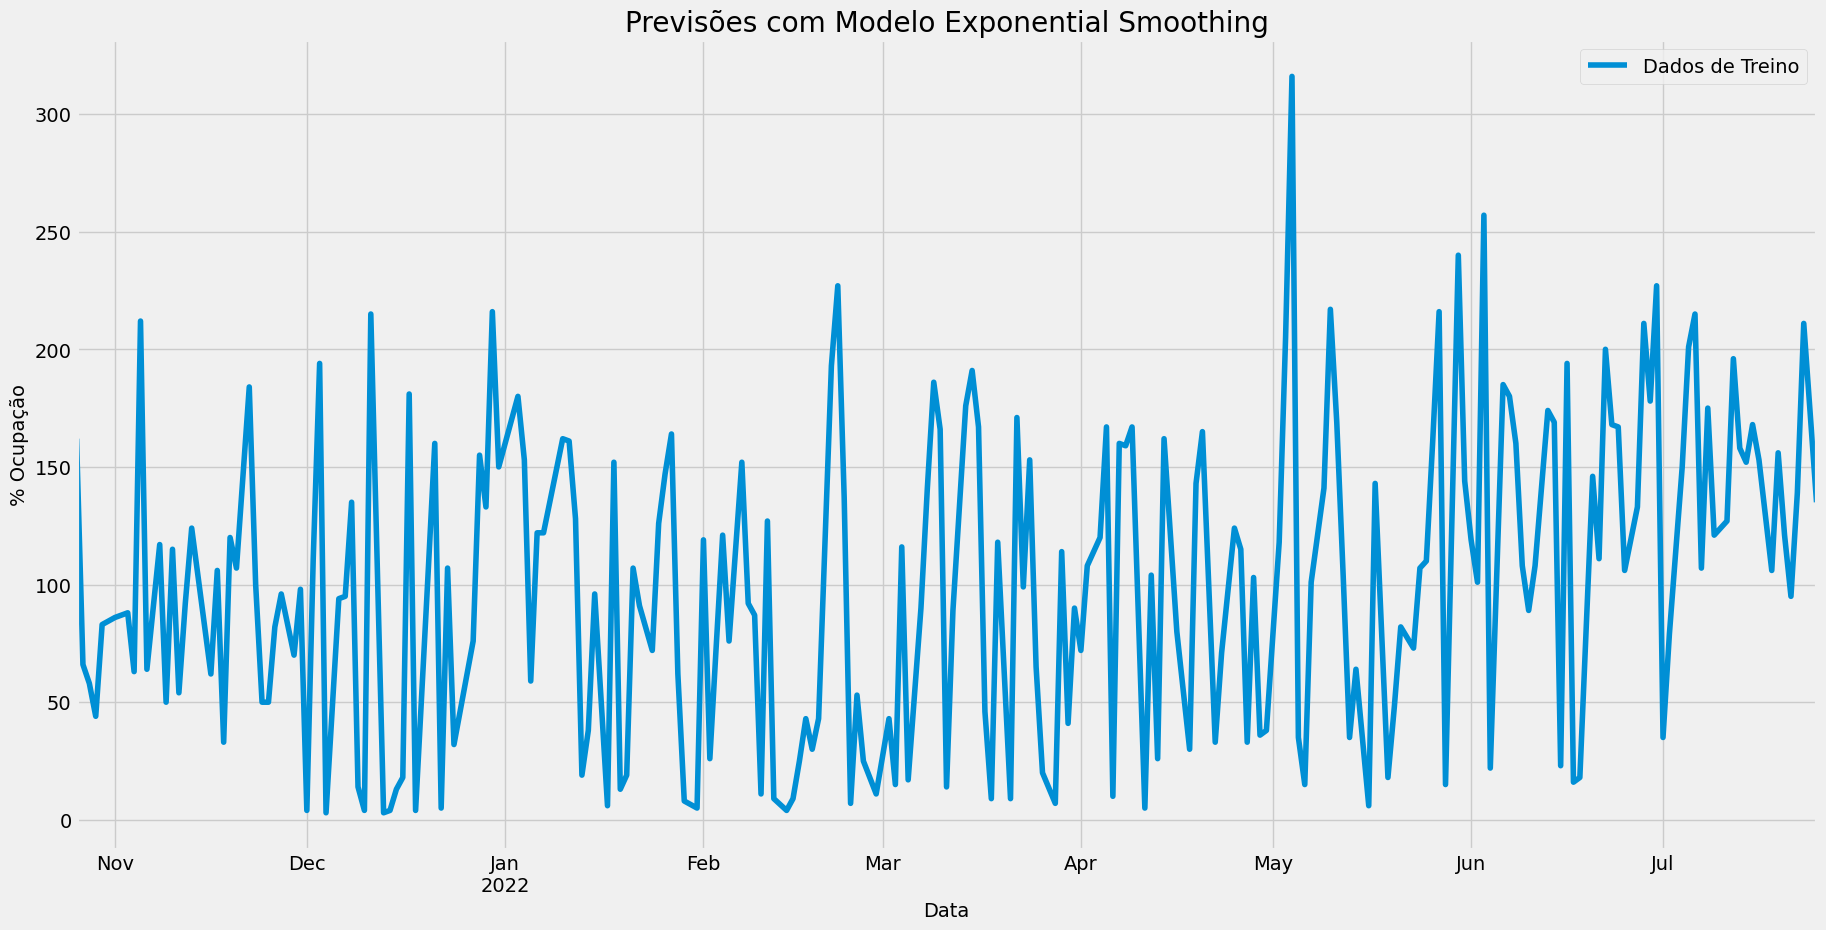

In [6]:
# Plot
treino.Quantidade.plot(title = 'Previsões com Modelo Exponential Smoothing', fontsize = 14, label = 'Dados de Treino') 
plt.xlabel("Data") 
plt.ylabel("% Ocupação") 
plt.legend(loc = 'best') 
plt.show()

## Forecasting - Modelagem Preditiva Para Séries Temporais

### Exponential Smoothing

A suavização exponencial é um método de previsão de séries temporais para dados univariados.



Vamos criar dois modelos de Suavização Exponencial usando o Statsmodels.

In [7]:
# Versão 1 do modelo - Simple Exponential Smoothing
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html

# A função SimpleExpSmoothing() recebe os dados de treino no formato de array numpy
# A função fit() faz o treinamento

# O hiperparâmetro smoothing_level define o nível de suavização exponencial na série
# O hiperparâmetro optimized define se teremos ou não otimização 

# Versão 1 do modelo - Simple Exponential Smoothing 
modelo_v1 = SimpleExpSmoothing(np.asarray(treino['Quantidade'])).fit(smoothing_level = 0.8, optimized = True) 

In [8]:
# Previsões com o Modelo
teste['previsoes_v1'] = modelo_v1.forecast(len(teste)) 

In [9]:
# Colocamos lado a lado, valor real e valor "previsto"
teste[['Quantidade', 'previsoes_v1']].head()

,Quantidade,previsoes_v1
Data,,
2022-07-26,217.0,143.483593
2022-07-27,336.0,143.483593
2022-07-28,113.0,143.483593
2022-07-29,238.0,143.483593
2022-07-30,11.0,143.483593


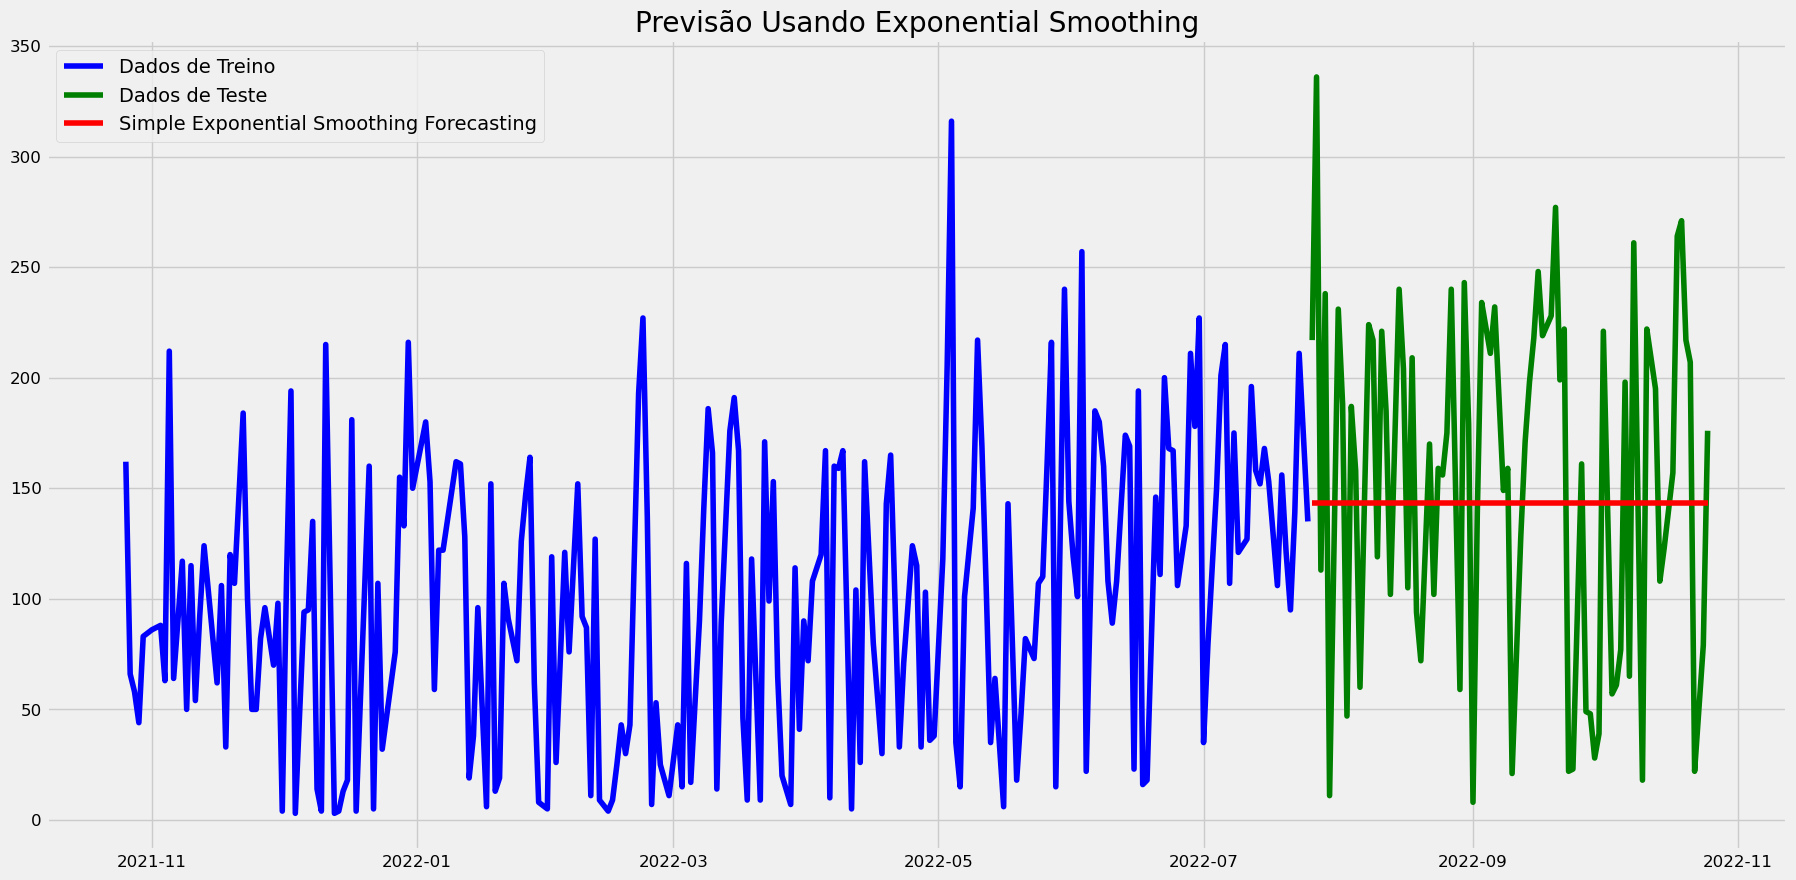

In [11]:
# Plot
plt.title("Previsão Usando Exponential Smoothing") 
plt.plot(treino['Quantidade'], label = 'Dados de Treino', color = 'blue')
plt.plot(teste['Quantidade'], label = 'Dados de Teste', color = 'green')
plt.plot(teste['previsoes_v1'], label = 'Simple Exponential Smoothing Forecasting', color = 'red') 
plt.legend(loc = 'best') 
plt.show()

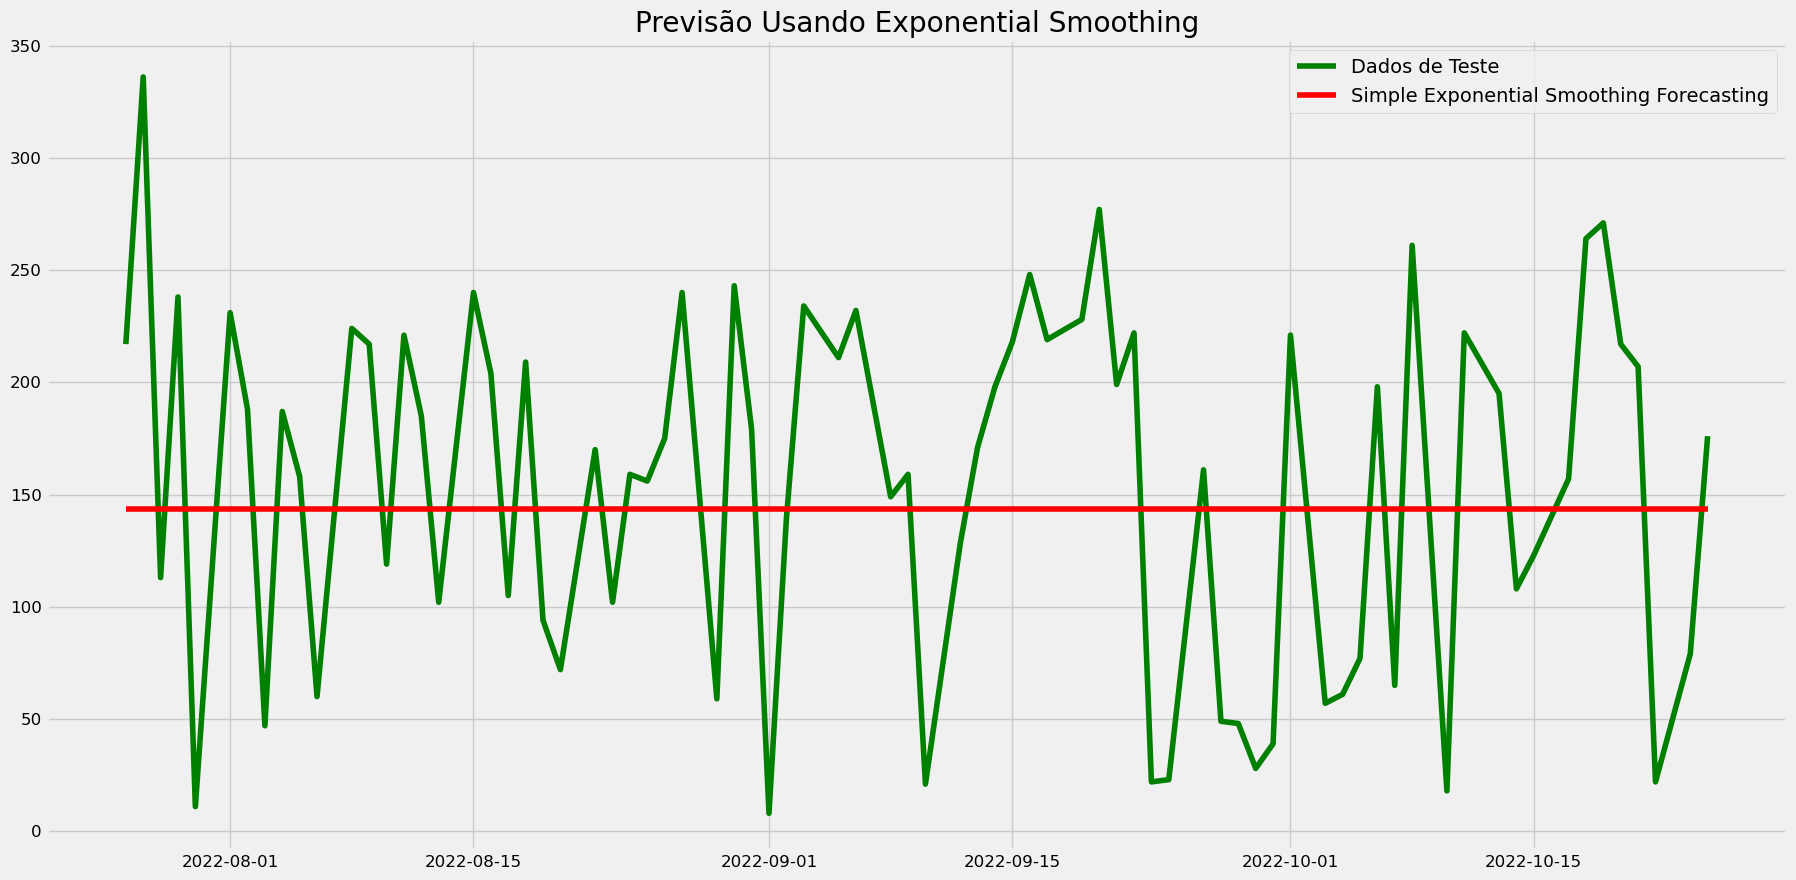

In [23]:
# Plot
plt.title("Previsão Usando Exponential Smoothing") 
plt.plot(teste.index, teste['Quantidade'], label = 'Dados de Teste', color = 'green') 
plt.plot(teste.index, teste['previsoes_v1'], label = 'Simple Exponential Smoothing Forecasting', color = 'red') 
plt.legend(loc = 'best') 
plt.show()

Pronto! Temos a previsão da nossa série! Você apresentaria esse modelo ao investidor disposto a investir no seu negócio? Espero que não!

Esse modelo não é muito melhor do que nosso modelo base. Vamos calcular o erro do modelo.

In [12]:
# Define valor real e valor previsto
y_true = teste.Quantidade
y_pred = teste.previsoes_v1

In [13]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

76.28170783515691


Nosso Modelo Base com o Método Naive obteve um RMSE de 77,7967. 

Nosso objetivo é reduzir o RMSE tanto quanto possível, pois essa métrica indica a taxa de erro do modelo. 

Reduzimos de 77,7967 para 76,2817. 

Ou seja, para essa série, um modelo de suavização exponencial simples melhor um pouco do que um modelo ingênuo (naive).

Será que conseguimos melhorar a performance do modelo preditivo? Vamos tentar outro tipo de suavização exponencial.

In [14]:
# Versão 2 do modelo - Double Exponential Smoothing 
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html

# Observe que estamos usando a função ExponentialSmoothing().
# Ao usar o hiperparâmetro trend, definimos o método Double Exponential Smoothing.
# Ao usar o hiperparâmetro seasonal, definimos o método Triple Exponential Smoothing.

# Vamos usar o Double. Como temos sazonalidade, não faz muito sentido usar o Triple.
# Escolhi a série aditiva
modelo_v2 = ExponentialSmoothing(np.asarray(treino['Quantidade']), trend = 'additive').fit(smoothing_level = 0.8, 
                                                                                         optimized = True) 

In [15]:
# Previsões com o Modelo
teste['previsoes_v2'] = modelo_v2.forecast(len(teste))

In [16]:
# Colocamos lado a lado, valor real e valor "previsto"
teste[['Quantidade', 'previsoes_v1', 'previsoes_v2']].head()

,Quantidade,previsoes_v1,previsoes_v2
Data,,,
2022-07-26,217.0,143.483593,142.878385
2022-07-27,336.0,143.483593,142.359937
2022-07-28,113.0,143.483593,141.841489
2022-07-29,238.0,143.483593,141.323041
2022-07-30,11.0,143.483593,140.804593


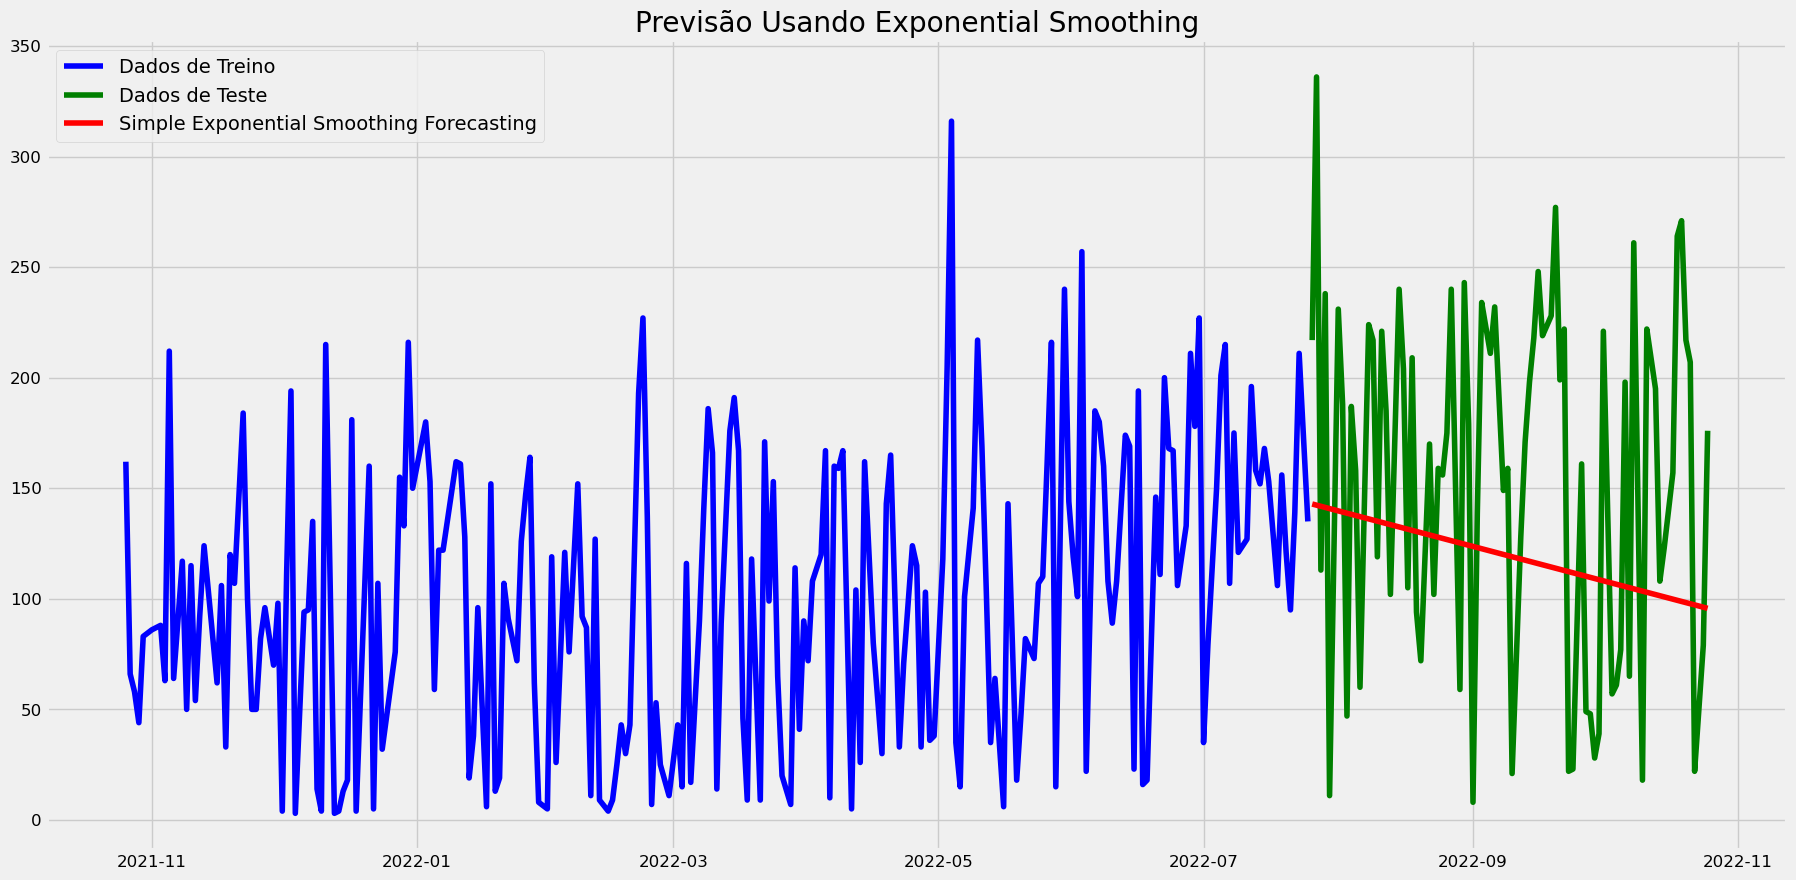

In [18]:
# Plot
plt.title("Previsão Usando Exponential Smoothing") 
plt.plot(treino['Quantidade'], label = 'Dados de Treino', color = 'blue')
plt.plot(teste['Quantidade'], label = 'Dados de Teste', color = 'green')
plt.plot(teste['previsoes_v2'], label = 'Simple Exponential Smoothing Forecasting', color = 'red') 
plt.legend(loc = 'best') 
plt.show()

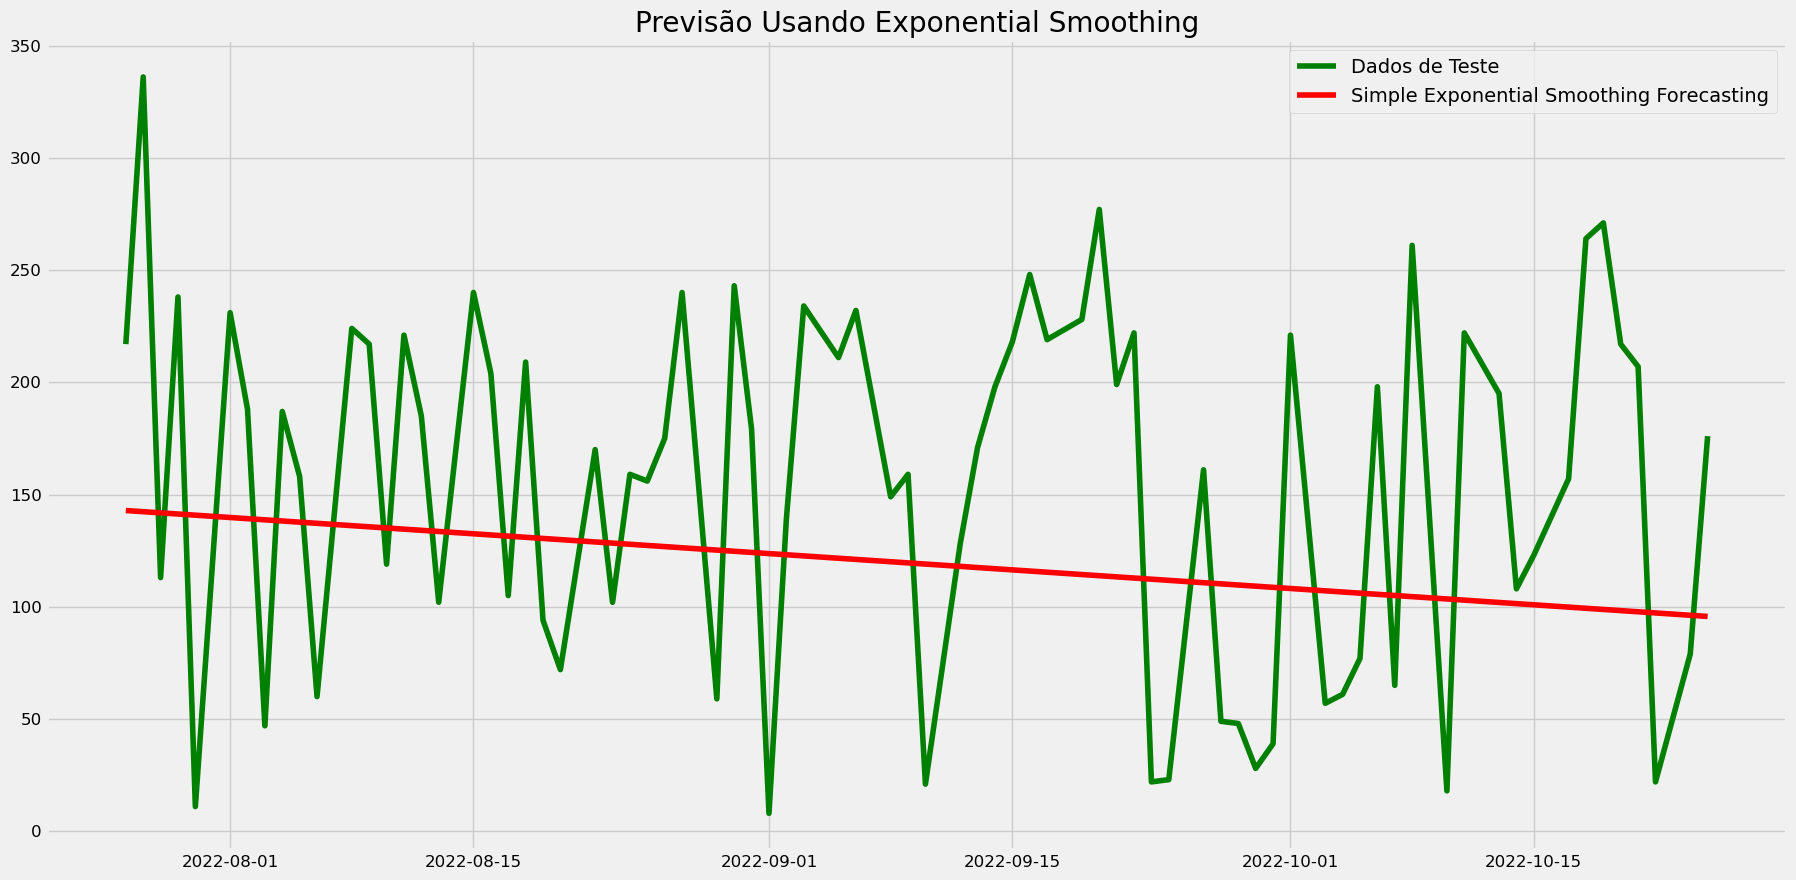

In [24]:
# Plot
plt.title("Previsão Usando Exponential Smoothing") 
plt.plot(teste.index, teste['Quantidade'], label = 'Dados de Teste', color = 'green') 
plt.plot(teste.index, teste['previsoes_v2'], label = 'Simple Exponential Smoothing Forecasting', color = 'red') 
plt.legend(loc = 'best') 
plt.show()

In [19]:
# Define valor real e valor previsto
y_true = teste.Quantidade
y_pred = teste.previsoes_v2

In [20]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

82.48530122837751


Opa! Tivemos uma piora razoável aqui.

Reduzimos de 77,7967 (naive) para 76,2817 (previsoes_v1) aumentou para 82,4853 (previsoes_v2).

Observe a linha amarela no gráfico. Ela começou a descer. Nosso objetivo é deixá-la semelhante à linha laranja. Chegaremos lá.


Todas as aulas deste curso foram adaptadas da timeline da Comunidade no Portal da DSA: www.datascienceacademy.com.br

# Fim